In [70]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import torchvision.transforms as T
import tqdm
import random
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cuda
NVIDIA GeForce GTX 1660 Ti


In [72]:
model = torch.hub.load("facebookresearch/detr", "detr_resnet101", pretrained=True)
model.to(device)
model.eval()

Using cache found in /home/youssef/.cache/torch/hub/facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [73]:
transform = T.Compose(
    [
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [74]:
validation_images = "/media/youssef/Programming/Faculty/level-4/2nd-term/CV/Computer_Vision_Assignments/asg4/COCO/val2017"
validation_annotations = "/media/youssef/Programming/Faculty/level-4/2nd-term/CV/Computer_Vision_Assignments/asg4/COCO/annotations/instances_val2017.json"

coco_gt = COCO(validation_annotations)
image_ids = coco_gt.getImgIds()

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [75]:
img_path = "/media/youssef/Programming/Faculty/level-4/2nd-term/CV/Computer_Vision_Assignments/asg4/COCO/val2017/000000000724.jpg"
im = Image.open(img_path).convert("RGB")
img = transform(im).unsqueeze(0)

In [76]:
img_info = coco_gt.loadImgs(image_ids[0])[0]
for field in img_info:
    print(f"{field}: {img_info[field]}")

license: 4
file_name: 000000397133.jpg
coco_url: http://images.cocodataset.org/val2017/000000397133.jpg
height: 427
width: 640
date_captured: 2013-11-14 17:02:52
flickr_url: http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg
id: 397133


In [84]:
img_path = os.path.join(validation_images, img_info["file_name"])
im = Image.open(img_path).convert("RGB")
img = transform(im).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img)

logits = outputs["pred_logits"]
print(logits.shape)

boxes = outputs["pred_boxes"]
print(boxes.shape)

torch.Size([1, 100, 92])
torch.Size([1, 100, 4])


## DETR to COCO conversion
- DETR: (x_center, y_center, width, height) normalized
- COCO: (x_min, y_min, width, height)

In [78]:
def detr_to_coco_bbox(detr_bbox, size):

    image_width, image_height = size

    x_center, y_center, w_norm, h_norm = detr_bbox

    w = w_norm * image_width
    h = h_norm * image_height
    x = (x_center * image_width) - w / 2
    y = (y_center * image_height) - h / 2

    return [x, y, w, h]

In [79]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

## Inference and save predictions to JSON

In [ ]:
results = []

for image_id in tqdm.tqdm(image_ids):
    img_info = coco_gt.loadImgs(image_id)[0]
    img_path = os.path.join(validation_images, img_info['file_name'])
    im = Image.open(img_path).convert('RGB')
    img = transform(im).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)

    prob = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = prob.max(-1).values > 0.5
    

    boxes = outputs['pred_boxes'][0, keep]
    labels = prob[keep].argmax(-1)
    scores = prob[keep].max(-1).values

    for box, label, score in zip(boxes, labels, scores):
        coco_box = detr_to_coco_bbox(box.tolist(), im.size)
        results.append({
            'image_id': image_id,
            'category_id': int(label.item()),
            'bbox': coco_box,
            'score': score.item()
        })

with open('results-COCO.json', 'w') as f:
    json.dump(results, f)

## Evaluation

In [81]:
coco_dt = coco_gt.loadRes("results-COCO.json")
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.params.imgIds = image_ids
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

map_50_95 = coco_eval.stats[0]
map_50 = coco_eval.stats[1]

print("\nmAP@0.5:0.95 = ", map_50_95)
print("mAP@0.5 = ", map_50)

Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.51s).
Accumulating evaluation results...
DONE (t=2.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

## Random Examples 

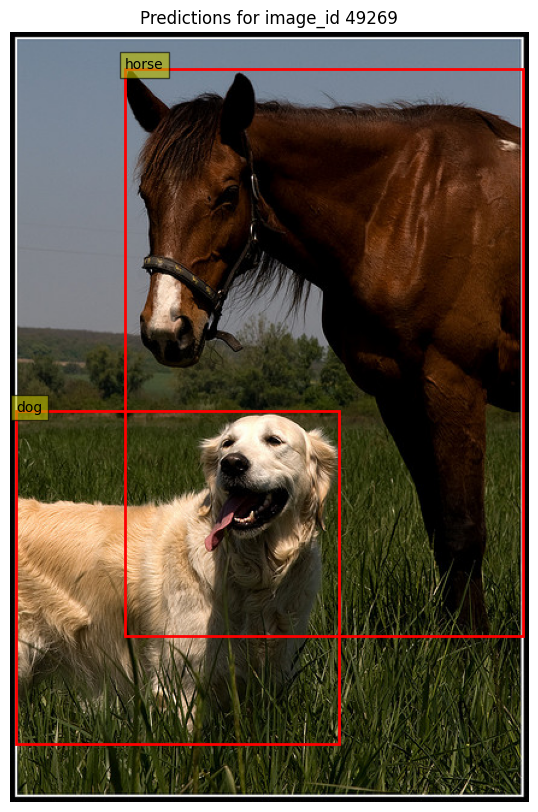

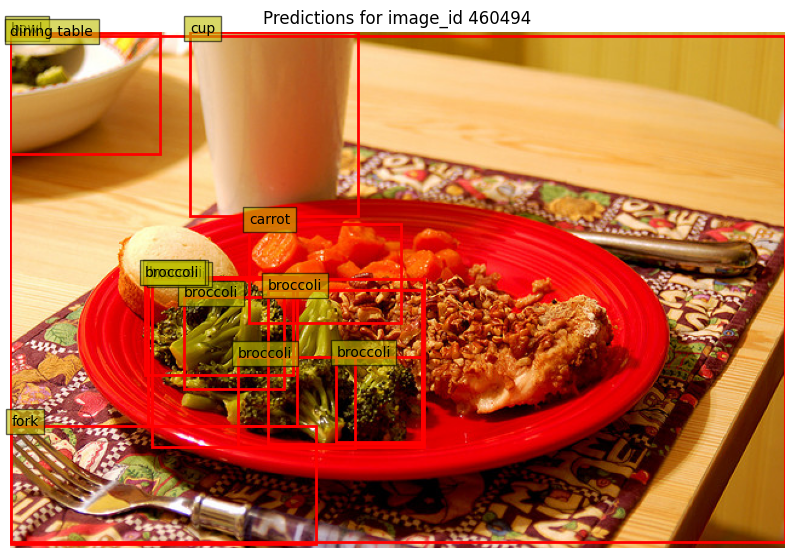

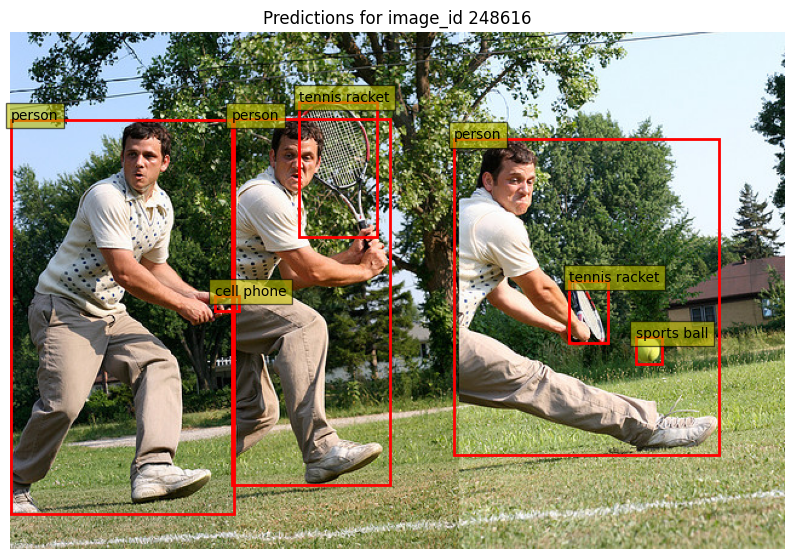

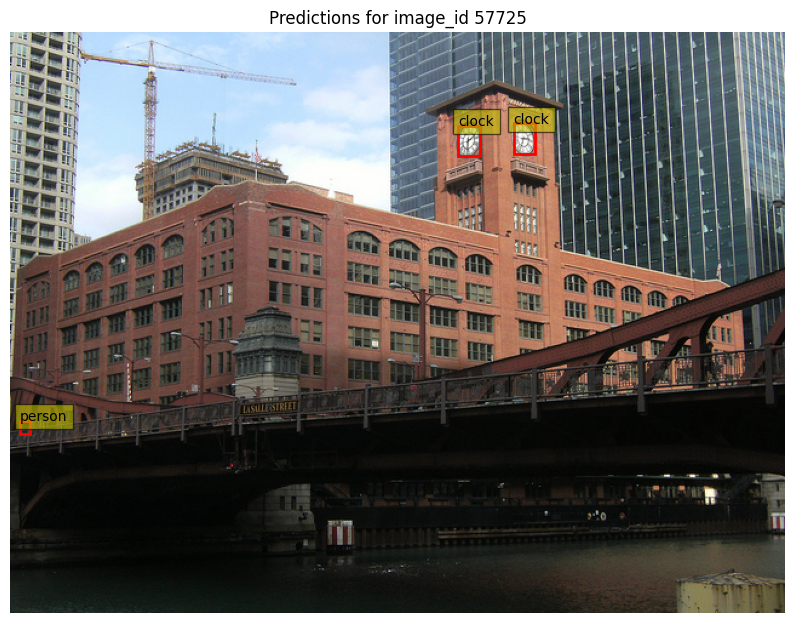

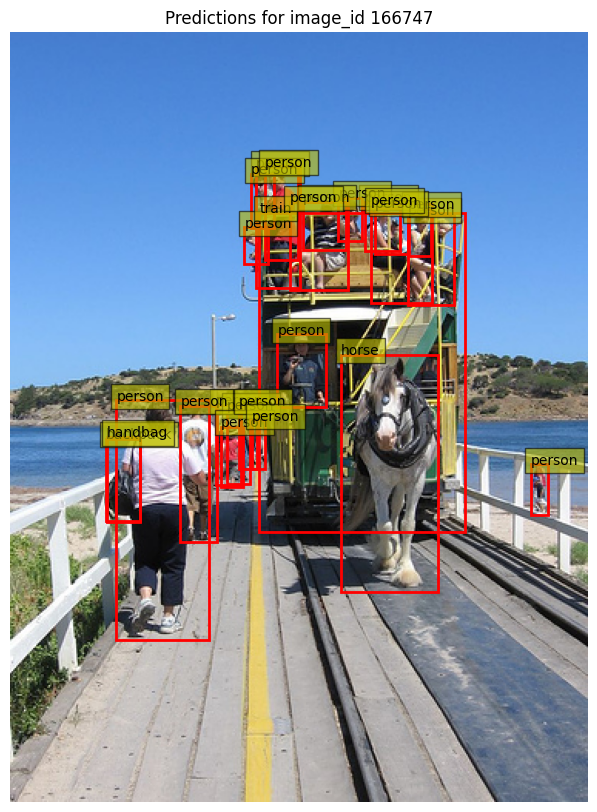

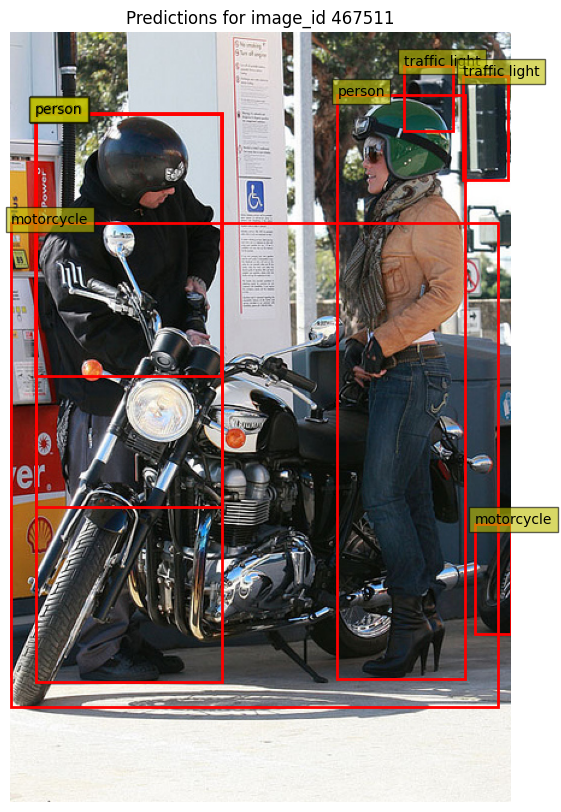

In [82]:
with open("results-COCO.json", "r") as f:
    results = json.load(f)

results_by_image = defaultdict(list)
for res in results:
    results_by_image[res["image_id"]].append(res)

random.seed(42)
all_image_ids = list(results_by_image.keys())
random_image_ids = random.sample(all_image_ids, 6)

for image_id in random_image_ids:
    img_info = coco_gt.loadImgs(image_id)[0]
    img_path = os.path.join(validation_images, img_info["file_name"])
    im = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    ax = plt.gca()

    for pred in results_by_image[image_id]:
        x, y, w, h = pred["bbox"]
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        cat_name = coco_gt.loadCats(pred['category_id'])[0]['name']
        plt.text(
            x,
            y,
            f"{cat_name}",
            color="black",
            fontsize=10,
            horizontalalignment="left",
            bbox=dict(facecolor="y", alpha=0.6),
        )

    plt.axis("off")
    plt.title(f"Predictions for image_id {image_id}")
    plt.show()

## Feature Maps of Early, Middle, and Late Layers

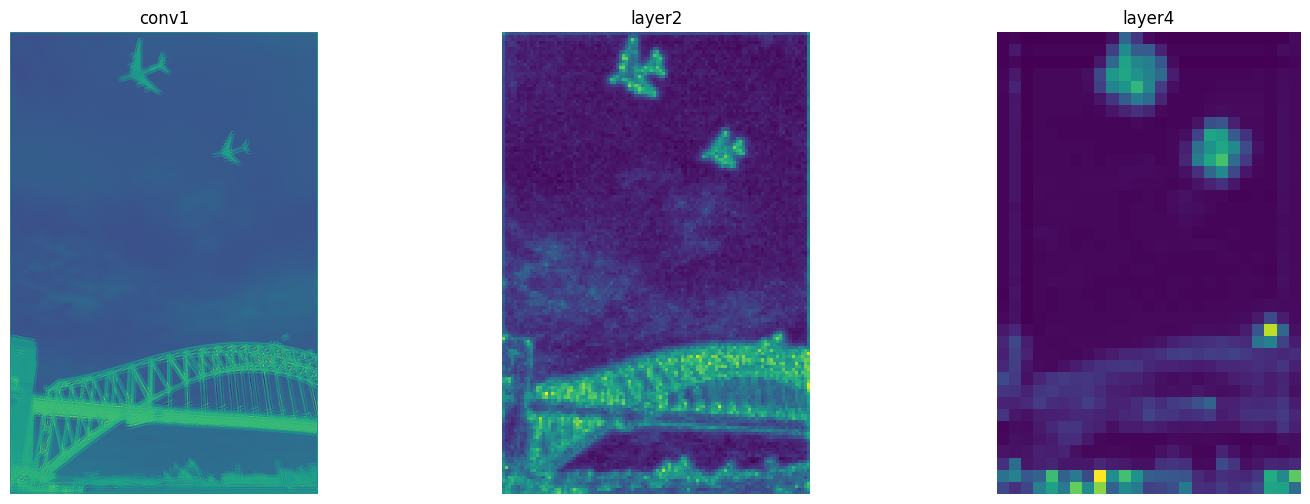

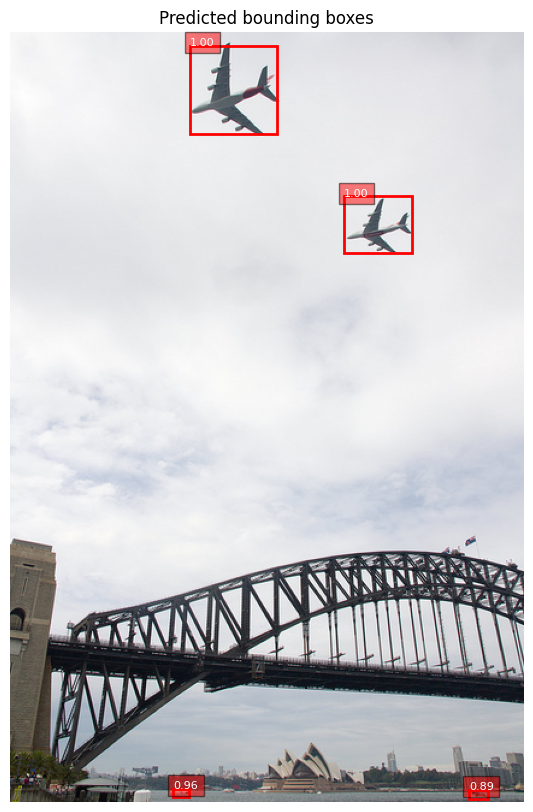

In [83]:
feature_maps = {}

def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

model.backbone[0].body['conv1'].register_forward_hook(get_activation('conv1'))     # Early
model.backbone[0].body['layer2'].register_forward_hook(get_activation('layer2'))   # Mid
model.backbone[0].body['layer4'].register_forward_hook(get_activation('layer4'))   # High

img_path = "/media/youssef/Programming/Faculty/level-4/2nd-term/CV/Computer_Vision_Assignments/asg4/COCO/val2017/000000001761.jpg"
im = Image.open(img_path).convert("RGB")
img = transform(im).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img)

plt.figure(figsize=(18, 6))
for i, name in enumerate(['conv1', 'layer2', 'layer4']):
    fmap = feature_maps[name][0]
    fmap_mean = fmap.mean(0)
    plt.subplot(1, 3, i+1)
    plt.imshow(fmap_mean, cmap='viridis')
    plt.title(f'{name}')
    plt.axis('off')

plt.show()

prob = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = prob.max(-1).values > 0.8

boxes = outputs['pred_boxes'][0, keep].cpu()
scores = prob[keep].max(-1).values.cpu()
labels = prob[keep].argmax(-1).cpu()

plt.figure(figsize=(10, 10))
plt.imshow(im)
ax = plt.gca()

for box, score in zip(boxes, scores):
    coco_box = detr_to_coco_bbox(box.tolist(), im.size)
    x, y, w, h = coco_box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    plt.text(
        x, y, f"{score:.2f}", color="white", fontsize=8,
        bbox=dict(facecolor="red", alpha=0.5)
    )

plt.axis("off")
plt.title("Predicted bounding boxes")
plt.show()